In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile

zf = zipfile.ZipFile('data-science-exercise-data.csv.zip', 'r')
print(zf.namelist())
filename = 'data-science-exercise-data.csv'
try:
    df = pd.read_csv(zf.extract(filename))
    df.Timestamp = pd.to_datetime(df['Timestamp'])
    print(df.info())
    print(df.head())
except KeyError:
    print('ERROR: Did not find {} in zip file'.format(filename))

['data-science-exercise-data.csv', '__MACOSX/', '__MACOSX/._data-science-exercise-data.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   CustomerID     49945 non-null  object             
 1   Timestamp      49945 non-null  datetime64[ns, UTC]
 2   PurchaseValue  49945 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 1.1+ MB
None
                         CustomerID                 Timestamp  PurchaseValue
0  5611860a94204a4078659f1667372cc4 2017-02-09 18:31:00+00:00           4.72
1  07b260307114f9cffc5601eb7ad4b565 2017-06-28 19:26:00+00:00           5.33
2  1ede55062d0d68c70fc4d355a5328d11 2017-07-28 17:47:00+00:00           5.35
3  42b8e86e8da5e35628bcdc146c358665 2016-12-17 22:59:00+00:00           6.00
4  1047f2787b7efc759d7ffcbc40ef7e19 2016-12-05 17:23:

In [193]:
print("Oldest date: {}\nMost recent date: {}".format(df.Timestamp.min(), df.Timestamp.max()))
print("Number of weeks: {}".format((df.Timestamp.max() - df.Timestamp.min()).days/7))
print("Number of unique customers: {}".format(df.CustomerID.nunique()))

Oldest date: 2016-11-30 04:47:00+00:00
Most recent date: 2017-12-06 17:53:00+00:00
Number of weeks: 53.0
Number of unique customers: 23708


In [194]:
# Group and aggregate the dataframe to show weekly purchases
total = df.groupby("Timestamp").agg({"CustomerID": "count"}).rename({"CustomerID":"all"}, axis = 1).reset_index()
initial = df.groupby("CustomerID").agg({"Timestamp": "min"}).reset_index()
all_ = total.merge(initial, how = "left", on = "Timestamp").groupby("Timestamp") \
                .agg({"CustomerID": "count", "all": "mean"})\
                .rename({"CustomerID": "initial"}, axis = 1).reset_index()\
                .assign(Timestamp = lambda df: df.Timestamp.map(lambda time: pd.to_datetime(time)))\
                .set_index("Timestamp")\
                .resample('W').sum()\
                .assign(repeat = lambda df: df['all'] - df['initial'])

# Group and aggregate the dataframe to calculate repurchase interval 

diff = df.sort_values(['CustomerID', 'Timestamp'])\
        .groupby('CustomerID').Timestamp.transform(pd.Series.diff).dt.days.dropna()

diff = diff.apply(lambda x: np.ceil(x/7))


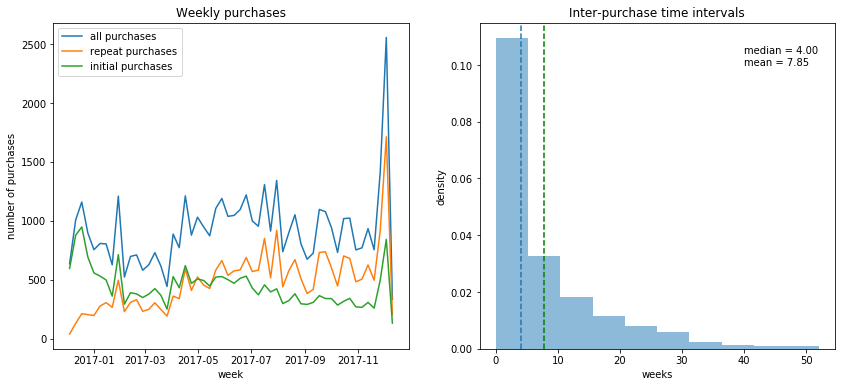

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(all_['all'], label = "all purchases")
ax1.plot(all_['repeat'], label = "repeat purchases")
ax1.plot(all_['initial'], label = "initial purchases")
ax1.legend()
ax1.set_xlabel("week")
ax1.set_ylabel("number of purchases")
ax1.set_title("Weekly purchases")

ax2.hist(diff, alpha = 0.5, density = True)
ax2.axvline(x = pd.Series.median(diff), linestyle = "--", label = "median")
ax2.axvline(x = pd.Series.mean(diff), linestyle = "--", label = "mean", color = "green")

ax2.set_xlabel("weeks")
ax2.set_title("Inter-purchase time intervals")
ax2.set_ylabel("density")

median_time = pd.Series.median(diff)
mean_time = pd.Series.mean(diff)
textstr = '\n'.join((
    r'median = %.2f' % (median_time, ),
    r'mean = %.2f' % (mean_time, )))
ax2.text(40, 0.10, textstr)
plt.show()

The plot on the left shows the weekly purchases decomposed into repeat purchases and initial purchases (assumed to be newcomers) similar to Figure 1 from <cite data-cite="7563040/HGAJXRBD"></cite>. Up to May 2017 there are more newcomers than returning customers, but the pace of newcomers slows down from the summer. Purchases are relatively high and stable during the summer and then sees the largest spike at the end of the year. Since the last date in the data is 2017-12-06, the spike at the end of November is most likely from Black Friday promotional sales.

The plot on the right filteres out the zero repurchasers and counts the inter-purchase time intervals measured in weeks. The distribution is highly skewed with the median at 4 weaks and the mean at 7.85 weeks. About half of the customers come back within 4 weeks while the other half do not come back again for almost a year. 

# Warmup/Basic Python

> 1. Implement the modified BG model from the lifetimes package using the data we provide.
> 2. List the 100 customers predicted to make the most purchases over the next 12 months.
> 3. List the 100 customers predicted to spend the most over the next 12 months.

First, I am going to I group and aggregate the original dataframe so that it consists of the following columns:

- `CustomerID` (unique customer ID);
- `recency` (the number of days between the customer's first and last purchase);
- `age` (the number of days duration between the customer's first purchase and the last datetime recorded in the sample);
- `frequency` (one less than the distinct number of dates when the customer made a purchase);
- `monetary_value` (average value of given customer's puchases). 

I followed <cite data-cite="7563040/EAQX5NC7"></cite> for calculation of these columns. 

In [196]:
df_agg = df.groupby("CustomerID").agg({"Timestamp": ['min', 'max', 'nunique'], 
                                       "PurchaseValue": ['count', 'sum']})
df_agg['recency'] = df_agg['Timestamp']['max'] - df_agg['Timestamp']['min']
df_agg['age'] = max(df.Timestamp) - df_agg['Timestamp']['min']
df_agg['frequency'] = df_agg['Timestamp']['nunique'] - 1

df_agg['monetary_value'] = df_agg['PurchaseValue']['sum']/df_agg['PurchaseValue']['count']

df_agg = df_agg.drop(['Timestamp', 'PurchaseValue'], axis = 1)
df_agg = pd.DataFrame.from_records(df_agg, index = df_agg.index)
df_agg[['recency', 'age']] = df_agg.select_dtypes('timedelta64[ns]').astype('timedelta64[D]')
df_agg.columns = [x[0] for x in df_agg.columns.to_flat_index()]
print(df_agg.head())
print(df_agg.info())

                                  recency    age  frequency  monetary_value
CustomerID                                                                 
0001117ff1305c1fe840697166e61564     10.0  343.0          1          87.765
00028502859fd7e111d88c20456b59d5      0.0  342.0          0          78.100
000306d200fd6e9b03de48d15348f5c2      0.0   33.0          0          98.440
0003f3458a6e7b495a975c2d9ddda559    284.0  342.0          2          81.470
000784b838b807ad589d4bc69c0c562f      0.0  210.0          0          85.780
<class 'pandas.core.frame.DataFrame'>
Index: 23708 entries, 0001117ff1305c1fe840697166e61564 to fffc0c75aa4e82c9856616b4c84e3f13
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         23708 non-null  float64
 1   age             23708 non-null  float64
 2   frequency       23708 non-null  int64  
 3   monetary_value  23708 non-null  float64
dtypes: float64(3), int64(1)
memory u

In [197]:
from lifetimes import ModifiedBetaGeoFitter
mbgf = ModifiedBetaGeoFitter(penalizer_coef = 0.0)
mbgf.fit(df_agg['frequency'], df_agg['recency'], df_agg['age'])
print(mbgf)

<lifetimes.ModifiedBetaGeoFitter: fitted with 23708 subjects, a: 0.78, alpha: 59.36, b: 2.02, r: 0.70>


In [198]:
mbgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.695904,0.031899,0.633382,0.758426
alpha,59.358840,2.308311,54.834550,63.883130
a,0.779886,0.052238,0.677500,0.882273
b,2.018217,0.227929,1.571475,2.464958


Below I plot the distribution of $\hat{\lambda} \sim \text{Gamma}(\hat{r}, \hat{\alpha})$ and $\hat{p} \sim \text{Beta}(\hat{a}, \hat{b})$.  

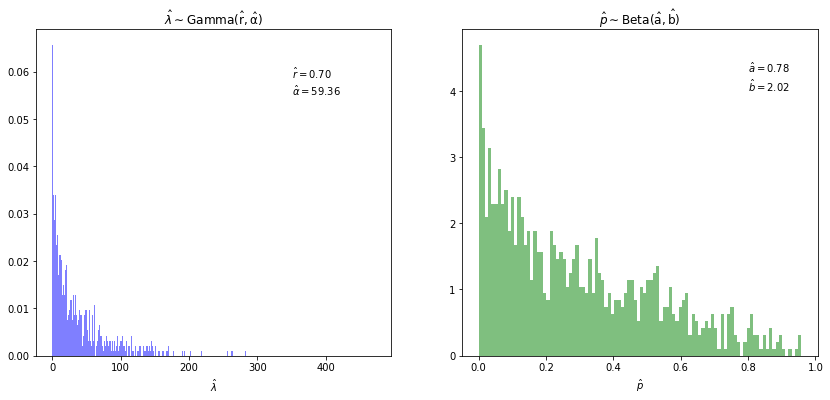

In [199]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
size = 1000
np.random.seed(1000)
lambda_hat = np.random.gamma(mbgf.params_['r'], mbgf.params_['alpha'], size)
p_hat = np.random.beta(mbgf.params_['a'], mbgf.params_['b'], size)

ax1.hist(lambda_hat, bins = 500, alpha = 0.5, density = True, color = 'b')
ax1.set_xlabel(r'$\hat{\lambda}$')
ax1.set_title(r'$\hat{\lambda} \sim \rm{Gamma}(\hat{r}, \hat{\alpha})$')
text1 = '\n'.join((
    r'$\hat{r} = %.2f$' % (mbgf.params_['r'], ),
    r'$\hat{\alpha} = %.2f$' % (mbgf.params_['alpha'], )))
ax1.text(350, 0.055, text1)

ax2.hist(p_hat, bins = 100, alpha = 0.5, density = True, color = 'g')
ax2.set_title(r'$\hat{p} \sim \rm{Beta}(\hat{a}, \hat{b})$')
ax2.set_xlabel(r'$\hat{p}$')
text2 = '\n'.join((
    r'$\hat{a} = %.2f$' % (mbgf.params_['a'], ),
    r'$\hat{b} = %.2f$' % (mbgf.params_['b'], )))
ax2.text(0.8, 4, text2)
plt.show()

## Top 100 customers predicted to make the most number of purchases

Now that we've fitted MBG/NBD model to the data we want to predict the number of purchases each customer would make over the next 12 months (= 365 days) based on the observed data. Then we will sort the customers by the most number of purchases and list the top 100. 

In [200]:
expected_purchases = mbgf.conditional_expected_number_of_purchases_up_to_time(365, 
                                                                df_agg['frequency'], 
                                                                df_agg['recency'], 
                                                                df_agg['age']).sort_values(ascending = False)
print(expected_purchases.head(100))

CustomerID
a5fadc51b1ae844ad9a70ad3cfa46a64    88.511041
48a503edbaded96a3be27deee11967a1    35.742201
9f447f9415a380ac2eeee7df49c6ee7e    28.123673
ca2202a96c2de6ca6b8a37a4a73fa730    26.559385
5f01420f0edda6555df5ce1cc62b986c    25.502714
                                      ...    
14526eaf59eef233af1e07b1a021f887     9.602975
25e5fe3494dcb7d0de25fcd6f6b499d9     9.595949
2ea8b33c3c481793d36d215fe64262be     9.558133
d88c16f53bf1f538e5dad005530611a9     9.553437
2da10b67a4882e14d257c728eda763c3     9.538682
Length: 100, dtype: float64


## Top 100 spenders predicted

Finally, we want to predict how much each customer would spend over the next 12 months and identify the top 100 customers. For this monetary value prediction, we will use Gamma-gamma model for monetary value (implemented by `GammaGammFitter`), which assumes that average transaction value, $Z$ is distributed $\text{Gamma}(\rho, \nu)$ where $E[z] = \rho/\nu$. The hyperparameter $\nu$ has gamma distribution with parameters $(q, \gamma)$ <cite data-cite="7563040/BZ8KNMY3"></cite>. 

The Gamma-Gamma model assumes that the average transaction value is independent of transaction frequency and assumes repeat purchases, so we will filter out zero repurchasers (i.e. those with `frequency == 0`) and check the correlation between `monetary_value` and `frequency`. The correlation is 0.011, which I consider to be low enough to not violate the model assumption. 

In [201]:
df_agg_returning = df_agg[df_agg.frequency > 0]
df_agg_returning[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015803
frequency,0.015803,1.000000


In [202]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(df_agg_returning['frequency'], df_agg_returning['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 10048 subjects, p: 7.52, q: 3.85, v: 91.30>


In [203]:
clv = ggf.customer_lifetime_value(
    mbgf, 
    df_agg['frequency'],
    df_agg['recency'],
    df_agg['age'],
    df_agg['monetary_value'],
    time = 12, # months
    freq = 'D',
    discount_rate=0.01).sort_values(ascending = False)
print(clv.head(100))

CustomerID
a5fadc51b1ae844ad9a70ad3cfa46a64    25226.459841
ca2202a96c2de6ca6b8a37a4a73fa730    16144.066219
5ac5ed64cd99ed2a8403b7a927e644ef    11920.116023
dca76db00cc59dfbcdcc97c8bbc7f9f1    10014.519756
60c19a709e3ced2d16d7100eb1069df5     9044.810164
                                        ...     
34bff14a781e6eabd03f59ac8f610ed7     2919.482266
7b054e89ebafd6033a234ec267bc60b5     2916.779671
888854e2551d1c54869ba39ba326fe76     2904.091911
323f6b3b7a7b0d114ea4bf79b6014241     2877.830805
6d165923bdf6c3055311418ef905c58a     2876.094852
Name: clv, Length: 100, dtype: float64


# Analysis 

> Explain the statistical assumptions that the model makes. Do you think those assumptions are valid for a model of a customer buying widgets from an ecommerce store?

Suppose we have a data on customers and their purchase history in the form of $X_i = (x, t_x, T)_i$ where $x$ is the frequency, $t_x$ is the time of the most recent purchase, and $T$ is the length of the observation time period. The modified BG/NBD model predicts customers' active/inactive status and future purchase activity.

The modified BG/NBD model has the same assumptions as the original BG/NBD model except for the third one. The BG/NBD model assumes the following:

1. The number of transactions that a customer made from time 0 to time $t \in (0, T]$ is $\rm{Poisson}(\lambda t)$.
This is equivalent to saying that the time between transactions is exponentially distributed with parameter $\lambda$ where the mean is $1/\lambda$. 

2. The transaction rate $\lambda$ has Gamma distribution with parameters $(r, \alpha)$.

3. The customer becomes inactive after a purchase with probability $p \sim \rm{Beta}(a, b)$.
    $$P(\text{customer becomes inactive after $j$th purchase}) = p(1-p)^{j-1}, \quad j = 1, 2, \ldots.$$
    
4. $\lambda$ and $p$ vary independently across customers. 

Modified BG/NBD alters assumption no. 3 by letting a customer become inactive at time 0 with probability $p \sim \rm{Beta}(a, b)$, so 
    $$P(\text{customer becomes inactive after $j$th purchase}) = p(1-p)^{j}, \quad j = 0, 1, 2, \ldots.$$

I will discuss whether these assumptions are valid for our data of customers.  

**Assumption no. 1** implies that transactions are made at a constant rate, but as we can see from the plot below, there are seasonal spikes in the number of purchases, namely in the summer and in the winter holiday season. The extent to which our model fit would be affected depends on the observation time period we select from the data. For instance, the model would perform poorly if we use the data from first half of the year to predict the second half of the year because the observation data on which we base the forecast on would not include the end of the year spike. 

**Assumption no. 2** allows for heteorgeneity in transaction rate among customers. This makes sense as it seems from though majority of customers make 0 repurchases, there is a sizable minority that made more than 2 repurchases. This makes sense as most customers would probably buy one widget component for fixing their electronics, but there are probably non-negligible number of customers who make frequent puchases for their business or their hobby. 

**Assumption no. 3** says that the more transaction a customer makes, the less likely that the customer is inactive. This sounds like a reasonable description for customers buying widgets on ecommerce store. Since most customers would only be buying a piece of widget to fix their personal eletronics, it is very likely that they will not return to the store for a while. On the other hand, a customer who buys widgets frequently most likely have a business or a hobby that requires frequent replenishing of widget items. Lifestyles are unlikely to change in a short amount of time, so the customer is very likely to be active the more purchases they make.


The modification to assumption no. 3 was made to account for customers with 0 repurchases, which make up almost 60% of the data. Customers who made 0 to 2 repurchases comprise more than 80% of the sample. Therefore, the modified version of assumption no. 3 is more approrpiate for this data. 

In [204]:
n = len(df_agg.index)
zeros = sum(df_agg['frequency'] == 0)
ones = sum(df_agg['frequency'] == 1)
twos = sum(df_agg['frequency'] == 2)
more = sum(df_agg['frequency'] > 2)

print("More than 2 repurchases: {0:.2f}".format(more/n))
print("2 repurchases: {0:.2f}".format(twos/n))
print("1 repurchases: {0:.2f}".format(ones/n))
print("0 repurchases: {0:.2f}".format(zeros/n))

More than 2 repurchases: 0.14
2 repurchases: 0.10
1 repurchases: 0.19
0 repurchases: 0.58


**Assumption no. 4** says that one customer's transaction rate and drop out rate do not depend on another customer's. This sounds very likely for an ecommerce store selling widgets because most customers visit the store independently and know what they need to buy. They might read product reviews on the product page to decide from which brand to buy if there is a choice, but this does not constitute a network effect where another customer inspires or motivates another customer who did not already intend to buy a product to buy one. A network effect is more likely to happen in, say, beauty and cosmetics store like Sephora where a review of a product is likely to attract other consumers to buy the product. 

# Simulation 

> Simulate how many customers are alive after 10 days, 1 year, 10 years and 100 years, and how many purchases they have made in that time using the modified BG model. Use a random sample of 100 customers and show the results for 1 run of your simulation. 

I will randomly select 100 customers from `df_agg` as a training data. I generate artificial data that simulates the behavior of 1000 new customers according to the estimated model parameters for each forecast period. 


Using my custom function `simulate_clv()`, I simulate how many purchases each of the randomly sampled customer will make over the next 10 days, 1 year, 10 years, and 100 years after 2017-12-06, the last date in the data. I generate a random seed so that this notebook will show a different simulation result every time it is run.

In [205]:
from lifetimes.generate_data import modified_beta_geometric_nbd_model

In [206]:
def simulate_clv(seed, n = 100, t = 10):
    """
    Using the parameters of the fitted model, generates an artificial data of `n` customers
    for observation period `t`. 
    Returns 'frequency' and 'alive' columns from the simulated data
    ------
    n (int, number of customers to generate)
    t (int, number of days to forecast)
    seed (int, random seed)
    """
    
    simulation = modified_beta_geometric_nbd_model(t, mbgf.params_['r'],
                                                     mbgf.params_['alpha'],
                                                     mbgf.params_['a'], 
                                                     mbgf.params_['b'], size = n)
    return simulation
    

r = np.random.seed() # generate random seed 
sim10d = simulate_clv(seed = r) # 10 days
sim1y = simulate_clv(t = 365, seed = r) # 1 year
sim10y = simulate_clv(t = 365 * 10, seed = r) # 10 years
sim100y = simulate_clv(t = 365* 100, seed = r) # 100 years

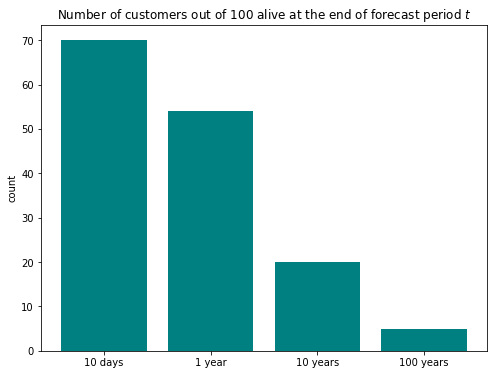

In [214]:
x = ['10 days', '1 year', '10 years', '100 years']
alive_count = [sim10d['alive'].sum(), sim1y['alive'].sum(), 
               sim10y['alive'].sum(), sim100y['alive'].sum()]

plt.figure(figsize = (8, 6))
plt.bar(x, alive_count, color = 'teal')
plt.ylabel('count')
plt.title(r'Number of customers out of 100 alive at the end of forecast period $t$')
plt.show()

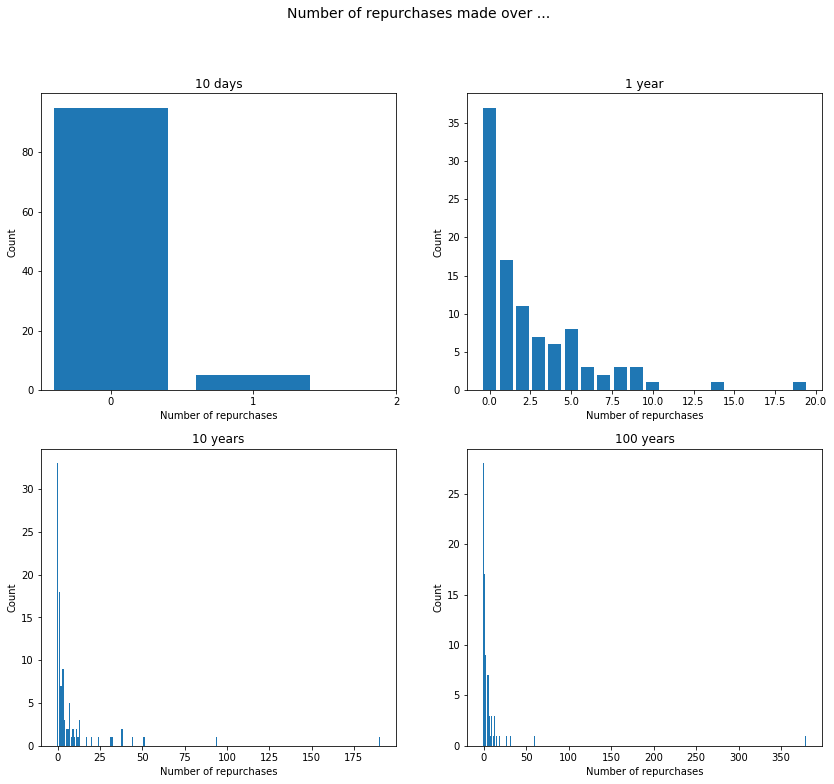

In [216]:
plt.rc('figure', titlesize=14)  # fontsize of the figure title
fig, axes = plt.subplots(2, 2, figsize = (14, 12))
axes = axes.flatten()
axes[0].bar(sim10d.frequency.value_counts().index, sim10d.frequency.value_counts())
axes[0].set_xticks([0, 1, 2])
axes[0].set_title('10 days')
axes[1].bar(sim1y.frequency.value_counts().index, sim1y.frequency.value_counts())
axes[1].set_title('1 year')
axes[2].bar(sim10y.frequency.value_counts().index, sim10y.frequency.value_counts())
axes[2].set_title('10 years')
axes[3].bar(sim100y.frequency.value_counts().index, sim100y.frequency.value_counts())
axes[3].set_title('100 years')
for i in range(0, 4):
    axes[i].set_xlabel('Number of repurchases')
    axes[i].set_ylabel('Count')
fig.suptitle("Number of repurchases made over ...")
plt.show()

# Analysis, 2

> The model works well in some ways and poorly in others for the data we provide. Explain what it does well and what it does poorly.
> What are one or two ideas that could address the deficiencies of the model? 

To show where the model performs well and where it does not, I will display two diagnostics plots. 

The first plot compares the frequencies of repeat transactions between the actual data and the data predicted by the model parameters. Since there is very little difference between the prediction and the actual data, it might seem like the model did well. However, this is due to overfitting because the model used the whole sample from 2016-11-30 to 2017-12-06 to estimate the parameters. Although this plot cannot be used to assess whether the model is informative, it still gives me confidence that the data generating process behind the data does not violate the model assumptions that I discussed earlier. Therefore, I would use this plot to conclude that the Modified BG/NBD model is appropriate for this customer population.

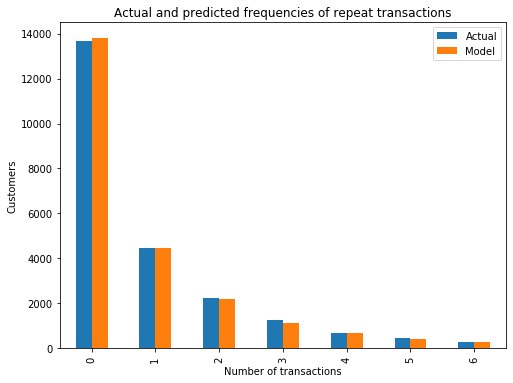

In [209]:
from lifetimes.plotting import plot_period_transactions
fig, ax = plt.subplots(figsize = (8, 6))
plot_period_transactions(mbgf, title = "Actual and predicted frequencies of repeat transactions", 
                         xlabel = "Number of transactions", ax = ax)
plt.show()

The second diagnostic plot is generated by splitting the data into training and testing set. Here, I chose different pairs of calibration/traning period and observation/testing period and plot the cross validation. The first row shows plots that were calibrated up to 2017-05-01, and the second row shows plots calibrated up to 2017-07-01. It is clear that calibrating up to 2017-07-01 gives better model fit. The plot, **"Weekly purchases"** at the beginning of the notebook shows that the number of total purchases was generally decreasing except for one spike around February and hit the lowest around April. However, the total purchases stabilize from May to July and at a slightly lower level from August to November until the (supposedly) Black Friday spike at the last week of November. Since the trend in the early portion of the year is different from the rest of the year, the forecast result of any model using only that portion of the data will not be reliable. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


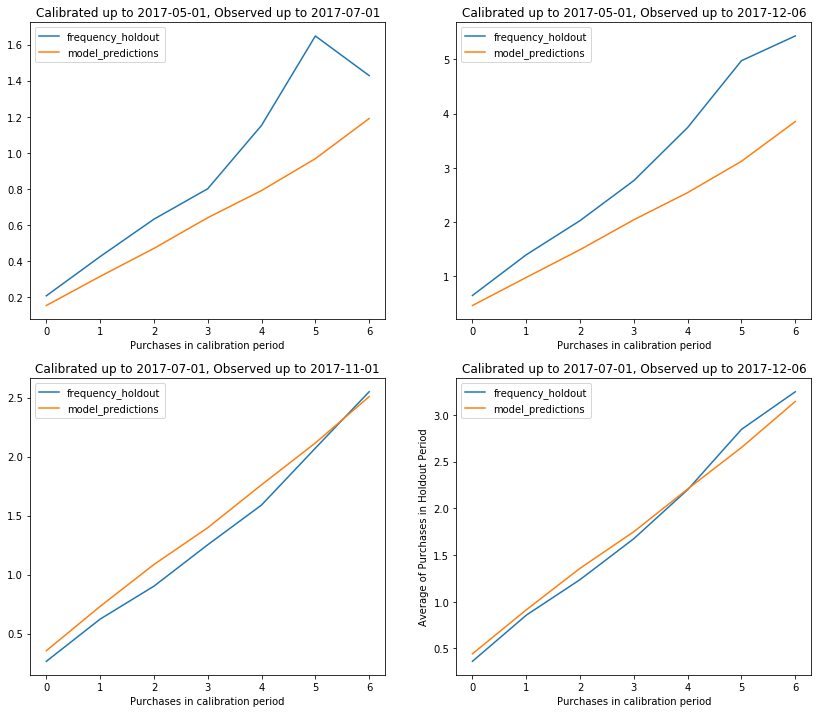

In [210]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

df.set_index('Timestamp', inplace = True)
df.index = df.index.tz_localize(None)
df.reset_index(inplace = True)

pairs = [('2017-05-01', '2017-07-01'), ('2017-05-01', '2017-12-06'), 
         ('2017-07-01', '2017-11-01'), ('2017-07-01', '2017-12-06')]

fig, axes = plt.subplots(2, 2, figsize = (14, 12))
for ax, pair in zip(axes.flatten(), pairs):
    (cal_period_end, obs_period_end) = pair
    summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'Timestamp',
                                        calibration_period_end = pd.to_datetime(cal_period_end).tz_localize(None), 
                                        observation_period_end = obs_period_end, freq = 'W')
    mbgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
    title = "Calibrated up to " + cal_period_end + ", Observed up to " + obs_period_end
    plot_calibration_purchases_vs_holdout_purchases(mbgf, summary_cal_holdout, ax = ax)
    ax.set_title(title)
    ax.set_xlabel('Purchases in calibration period')

In conclusion, modified BG model works well for the customer base buying widgets at this ecommerce store, but the performance of the model is sensitive to the length of the time period covered in the training/calibration data. If the store plans to hold seasonal promotions throughout the year, then I would recommend that the training data cover the whole year at minimum.

# Explain

> Suppose the intended use of the modified BG model is binning customers into one of the following categories: highly likely to purchase in the next year, somewhat likely to purchase in the next year, unlikely to purchase in the next year, highly unlikely to purchase in the next year. Suppose you want to compare this model with a model your colleague is proposing. How would you evaluate the two models? Do not implement, but do show a mockup of the results of your evaluation.

The main task is to figure out how to categorize each customer into one of the four categories: *highly likely*, *somewhat likely*, *unlikely*, and *highly unlikely*. For each customer, the function `expected_number_of_purchases_up_to_time()` generates how many purchases the customer is expected to make in the future period of length $t$ given their purchase history, denoted $E[Y(t)|x, t_x, T, r, \alpha, a, b]$ for $[T, T+t)$ in <cite data-cite="7563040/HGAJXRBD"></cite> and <cite data-cite="7563040/374FII9B"></cite>. I will call this value *expected frequency*. At the beginning of the year, for each customer in the database I will calculate the expected frequency for the next 365 days ($t = 365$). The intuition behind my classification scheme is that customers with higher expected frequency are more likely to be active and therefore more likely to buy again next year and vice versa. 

1. Sort the list of expected frequencies in descending order.
2. Create two plots: one comparing the observed frequency against the expected frequency and a histogram of expected frequency (cf. first row of plots below).
3. Use the plots created in the first step to identify outliers with high expected frequency. These outliers will be labeled *highly likely*. 
4. Repeat step 1 with outliers removed (cf. bottom row of plots below). The histogram created at this step should have binsize 1. 
5. Customers in the first bin ($0 \leq \textit{expected frequency} \leq 1$) will be labeled *highly unlikely*.
6. The remaining customers whose expected frequency is larger than 1 and smaller than the smallest outlier will be split in half by the median. The lower half will be labeled *somewhat likely*, and the upper half will be labeled *unlikely*. 

For this example, I am going judge by my eyes whether a point is an outlier. For a more objective method, Step 2 can be done by drawing a linear regression and identify points with high Cook's distance and residual. I assume that outliers will occur at higher end of expected frequency since most predictions are 0 to 1 repurchases. 

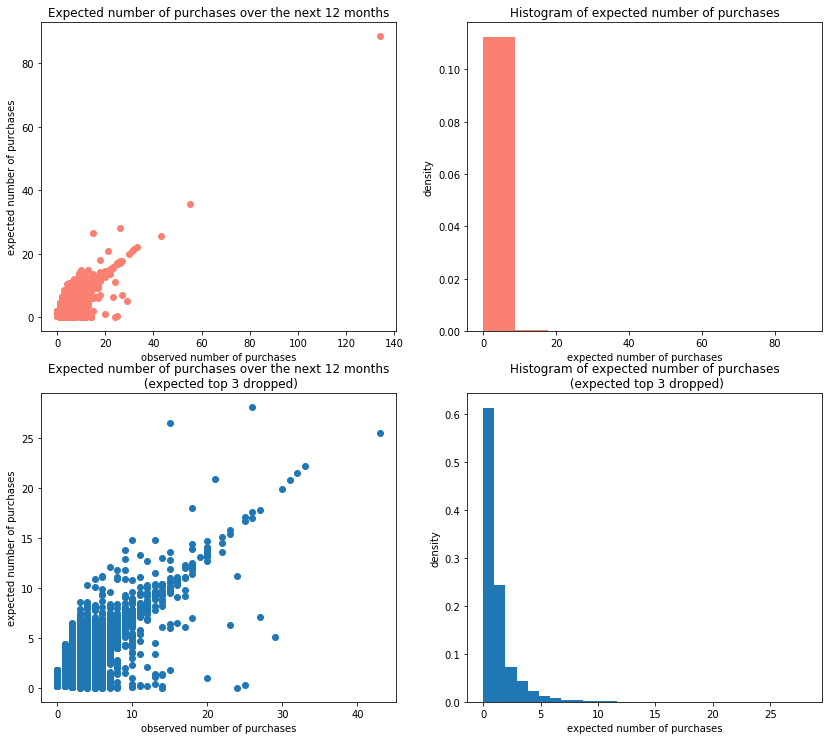

In [211]:
EY = df_agg.merge(expected_purchases.to_frame(name = "expected_freq"), 
                    on = "CustomerID", right_index = True)
EY_dropped = EY.drop(['a5fadc51b1ae844ad9a70ad3cfa46a64', 
                   '48a503edbaded96a3be27deee11967a1', '5ac5ed64cd99ed2a8403b7a927e644ef'], axis = 0) #drop the top 3

fig, axes = plt.subplots(2, 2, figsize = (14, 12.5))
axes = axes.flatten()
axes[2].scatter(EY_dropped['frequency'], EY_dropped['expected_freq'])
axes[2].set_title("Expected number of purchases over the next 12 months\n (expected top 3 dropped)")
axes[2].set_ylabel("expected number of purchases")
axes[2].set_xlabel("observed number of purchases")

axes[3].hist(EY_dropped['expected_freq'], density = True, bins = 29)
axes[3].set_xlabel("expected number of purchases")
axes[3].set_ylabel("density")
axes[3].set_title("Histogram of expected number of purchases\n (expected top 3 dropped)")

axes[0].scatter(EY['frequency'], EY['expected_freq'], color = 'salmon')
axes[0].set_title("Expected number of purchases over the next 12 months")
axes[0].set_ylabel("expected number of purchases")
axes[0].set_xlabel("observed number of purchases")

axes[1].hist(EY['expected_freq'], density = True, color = 'salmon')
axes[1].set_xlabel("expected number of purchases")
axes[1].set_ylabel("density")
axes[1].set_title("Histogram of expected number of purchases")


plt.show()

In [213]:
# Step 1
expected_purchases = expected_purchases.sort_values(ascending = False) 

# Step 3
highly_likely = expected_purchases[0:3]

# Step 5
highly_unlikely = expected_purchases.loc[expected_purchases <= 1]

# Step 6
remaining = expected_purchases.drop(index = highly_unlikely.index).drop(index = highly_likely.index)
somewhat_likely = remaining.loc[remaining >= remaining.median()] #inclusive of median
unlikely = remaining.loc[remaining < remaining.median()]

print(
    '\n'.join(('Highly likely: {}'.format(len(highly_likely)),
                 'Somewhat likely: {}'.format(len(somewhat_likely)),
                 'Unlikely: {}'.format(len(unlikely)),
                 'Highly unlikely: {}'.format(len(highly_unlikely))))
)

Highly likely: 3
Somewhat likely: 4680
Unlikely: 4680
Highly unlikely: 14345


The next task is to design a prediction score that can be calculated in the same way for both my and my colleague's model at the end of the year. 

One idea is to calculate the proportion of customers in each category who purcahsed and take their average. Whichever model has the higher average will be deemed to be more accurate. The formula for this prediction score is


$$\text{prediction score}_1 = \dfrac{1}{K}\sum_{k = 1}^K \dfrac{x_k}{n_k}$$ 

where $x_k$ is the number of customers in category $k$ that bought at the store again during the predicted year and $n_k$ is the size of the category. $K = 4$ by default.

A second, and less naive, idea is to use a weighted average. Since the size of each category is different, I assume that categories with larger size will more likely be precise than categories with smaller size. Therefore, I will weigh each category proportion by the inverse of square root of the category size. 

$$ \text{prediction score}_2 = \dfrac{1}{K} \sum_{k=1}^K \dfrac{x_k}{n_k}w_k$$
where weight for category $k$ is $w_k = \dfrac{1}{\sqrt{n_k}}$.


Since both formulae use $x_k$ and $n_k$, either one can be used to compare my model against my colleague's model. A more sophisticated version would incorporate uncertainty associated with predicting each category (e.g. *highly likely* and *highly unlikely* have more certainty than *somewhat* or *unlikely*). The challenge in that case is to come up with a way to quantify the level of uncertainties in the same way for both models. 

# References

<div class="cite2c-biblio"></div>